In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
cd /content/drive/My Drive/CIS581

/content/drive/My Drive/CIS581


In [3]:
'''
import library 
'''
import numpy as np
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
%matplotlib inline

from helpers import interp2

In [4]:
!pip install -U opencv-contrib-python==3.4.2.17
import cv2

Requirement already up-to-date: opencv-contrib-python==3.4.2.17 in /usr/local/lib/python3.6/dist-packages (3.4.2.17)


In [5]:
'''
Function (modify)
'''
def compute_homography(p1, p2):	
  """
  compute the homography transform
  p1, p2: 4 x 2, 4 groups of corresponding points
  """	
  # construct the A matrix in the same way in the slides
  A = np.zeros((8,9))

  for i in range(8):
      j = i//2
      if i % 2 == 0:
          A[i][0] = p2[j][0]
          A[i][1] = p2[j][1]
          A[i][2] = 1
          A[i][6] = -1 * p2[j][0] * p1[j][0] 
          A[i][7] = -1 * p2[j][1] * p1[j][0] 
          A[i][8] = -1 * p1[j][0]
      else:
          A[i][3] = p2[j][0]
          A[i][4] = p2[j][1]
          A[i][5] = 1
          A[i][6] = -1 * p2[j][0] * p1[j][1] 
          A[i][7] = -1 * p2[j][1] * p1[j][1] 
          A[i][8] = -1 * p1[j][1]

  # use SVD to find the solution to Ax = 0
  (_, _, V) = np.linalg.svd(A)

  H = V[8] / V[8][8]

  # reorgnize the solution vector and normalize it to get homography matrix
  H = H.reshape((3, 3))
  return H

In [6]:
## Test ##
p1 = np.array([[366.6972,  106.9789],
  [439.9366,   84.4437],
  [374.5845,  331.2042],
  [428.6690,  326.6972]])

p2 = np.array([ [115.0000,  120.0000],
  [194.0000,  107.0000],
  [109.0000,  351.0000],
  [169.0000,  346.0000] ])
H = compute_homography(p1, p2)

assert np.allclose(H, np.array([[ 6.76097539e-01,  9.12020085e-02,  2.61445474e+02],
       [-1.57581282e-01,  9.59039559e-01,  5.18593524e+00],
       [-4.93549913e-04,  9.67378471e-05,  1.00000000e+00]]))

In [7]:
def plot_corr(I1, I2, p1, p2):
  """
  utility function to plot correspondence between p1 in I1 and p2 in I2

  I1, I2: H * W, two input images of the same size
  p1, p2: N * 2, points on two images 
  """
  I = np.hstack((I1, I2))
  sy,sx = I1.shape[0:2]

  plt.figure()
  plt.imshow(I)
  plt.plot(p1[:, 0], p1[:, 1],'bo')
  plt.plot(sx + p2[:, 0], p2[:, 1],'rx')
  plt.plot(np.c_[p1[:, 0], sx + p2[:, 0]].T, np.c_[p1[:, 1],p2[:, 1]].T, 'g-')
  plt.show()

In [8]:
'''
Function (modify)
'''
def match_features(f1,f2):
  """
  f1, f2: N * feature_size, two features to be matched
  """
  
  # IMPLEMENT HERE
  # hint: you may find cdist from scipy.spatial.distance, numpy.argsort useful

  # compute pairwise distance between f1 and f2
  d = cdist(f1, f2)
  n, m = d.shape

  # forward matching, find closet two matches in f2 to f1 and do a ratio test
  idx = np.argsort(d, axis=1)
  sorted_d_i = np.take_along_axis(d, idx, axis=1)

  fwd_match_res = []
  for i in range(n):
    f_distances = sorted_d_i[i]
    if f_distances[1] == 0:
      fwd_match_res.append([i, idx[i][0]])
    elif f_distances[0] / f_distances[1] < 0.7: 
      fwd_match_res.append([i, idx[i][0]])

  # backward matching, find closet two matches in f1 to f2 and do a ratio test
  d_transposed = d.T
  jdx = np.argsort(d_transposed, axis=1)
  sorted_d_j = np.take_along_axis(d_transposed, jdx, axis=1)

  bkwd_match_res = []
  for j in range(m): 
    f_distances = sorted_d_j[j]
    if f_distances[1] == 0:
      bkwd_match_res.append([jdx[j][0], j])
    elif f_distances[0] / f_distances[1] < 0.7: 
      bkwd_match_res.append([jdx[j][0], j])

  # get the intersect of two matching as the final result, python set 
  intersect = set(map(tuple, fwd_match_res)) & set(map(tuple, bkwd_match_res))
  res = np.array(list(intersect))
  
  # return match, match_fwd, match_bkwd
  return res, fwd_match_res, bkwd_match_res

In [9]:
## Test ##
a = np.array([[2, 3],[5, 8],[4, 10]])
b = np.array([[10, 2],[2, 3],[5, 7],[1, -10]])
match, match_fwd, match_bkwd = match_features(a, b)
assert np.allclose(match, np.array([[0, 1],[1, 2]]))
assert np.allclose(match_fwd, np.array([[0, 1],[1, 2],[2, 2]]))
assert np.allclose(match_bkwd, np.array([[0, 1],[1, 2]]))

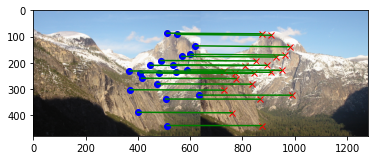

In [10]:
"""
Script (do not modify)
"""

# load images in OpenCV BGR format
I1 = cv2.imread('yosemite1.jpg')
I2 = cv2.imread('yosemite2.jpg')

# create grayscale images
I1_gray = cv2.cvtColor(I1, cv2.COLOR_BGR2GRAY)
I2_gray = cv2.cvtColor(I2, cv2.COLOR_BGR2GRAY)

# convert images to RGB format for display
I1 = cv2.cvtColor(I1, cv2.COLOR_BGR2RGB)
I2 = cv2.cvtColor(I2, cv2.COLOR_BGR2RGB)

# compute SIFT features
sift = cv2.xfeatures2d.SIFT_create()
kp1, des1 = sift.detectAndCompute(I1_gray, None)
kp2, des2 = sift.detectAndCompute(I2_gray, None)

# match features
match, match_fwd, match_bkwd = match_features(des1, des2)

# get corresponding points p1, p2 
p1 = np.array([kp.pt for kp in kp1])[match[:, 0]]
p2 = np.array([kp.pt for kp in kp2])[match[:, 1]]

# plot first 20 matching points 
plot_corr(I1, I2, p1[:20], p2[:20])

In [11]:
'''
Function (modify)
'''
def ransac_homography(p1, p2):
  """
  p1, p2: N * 2, correponding point coordinates
  """
  n = p1.shape[0]

  # decide how many loops to run and what the threshold is
  w = 0.5
  p = 1 - 0.0001
  k = int(np.ceil(np.log1p(1-p) / np.log1p(1-(w ** n))))

  threshold = 1

  n_best = -1
  best_H = np.zeros((8,9))

  indices = [i for i in range(n)]

  # RANSAC loop, inside in the loop
  for i in range(k):
    # 1. randomly pick n samples from p1 and p2 that is enough to fit a model(n=4 here)
    random_indices = np.random.choice(indices, size=4, replace=False)

    p1_subset = [p1[index] for index in random_indices]
    p2_subset = [p2[index] for index in random_indices]

    # 2. fit the model and get a estimation
    H = compute_homography(p1_subset, p2_subset)

    # 3. count consensus(# of inliners that is close to the estimation within the threshold)
    p2_normalized = np.hstack((p2, np.ones((n, 1))))
    p1_res = np.dot(p2_normalized, H.T)
    p1_res = p1_res[:,:2] / p1_res[:,2,None]

    p1_distances = [np.sqrt((p1_res[i][0] - p1[i][0])**2 + (p1_res[i][1] - p1[i][1])**2) for i in range(n)]

    n_inliers = 0
    for i in range(n):
      if p1_distances[i] < threshold:
        n_inliers += 1

    # 4. update the best estimation if the current one is better
    if n_inliers > n_best:
      best_H = H
      n_best = n_inliers  
  return best_H

In [14]:
## Test ##
p2 = np.random.randint(20, 200, size=(10, 2))
p2_ = np.hstack((p2, np.ones((10, 1)))).T
H = np.array([[ 6.76097539e-01,  9.12020085e-02,  2.61445474e+02],
       [-1.57581282e-01,  9.59039559e-01,  5.18593524e+00],
       [-4.93549913e-04,  9.67378471e-05,  1.00000000e+00]])
p1_ = H @ p2_
p1 = p1_ / p1_[-1, :]
p1 = p1[:2]
p1[:, -1] += 50
p1 = p1.T
assert np.allclose(H, ransac_homography(p1, p2))

[[ 1.18e+00  2.44e+00 -2.20e+01]
 [-1.43e+00  5.26e+00 -2.50e+01]
 [-1.00e-02  2.00e-02  1.00e+00]]


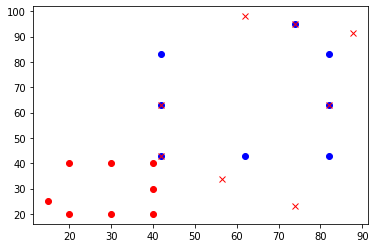

In [15]:
p2= np.array([[20, 20],
              [20, 30],
              [20, 40],
              [40, 20],
              [40, 30],
              [40, 40],
              [30, 20],
              [30, 40]])

p2_ = np.hstack((p2, np.ones((p2.shape[0], 1)))).T

H = np.array([[2,  0,  2],
              [0,  2,  3],
              [0,  0,  1]])
p1_ = H @ p2_
p1 = p1_ / p1_[-1, :]
p1 = p1[:2]
p1[:, -1] += 12 # add noise
p1 = p1.T

p2[1, :] -=5 # add noise
plt.plot(p2[:, 0], p2[:, 1], 'ro')
plt.plot(p1[:, 0], p1[:, 1], 'bo')

H_hat = ransac_homography(p1, p2)
print(H_hat)
p2_ = np.hstack((p2, np.ones((p2.shape[0], 1)))).T
p1_hat_ = H_hat @ p2_
p1_hat = p1_hat_ / p1_hat_[-1, :]
p1_hat = p1_hat[:2]
p1_hat = p1_hat.T
plt.plot(p1_hat[:, 0], p1_hat[:, 1], 'rx')

In [17]:
"""
Function (do not modify)
"""
def stitch(I1, I2, H):
    """
    utility function to stitch two images

    Input:

    I1: H1 x W1 x 3, target image
    I2: H2 x W2 x 3, source image
    H: homography matrix such that I1 = H @ I2

    Output:
    I_: stitching result
    """
    (H2, W2, _) = I2.shape
    
    I2_x = np.arange(W2)
    I2_y = np.arange(H2)

    # Use meshgrid to get all xs and ys
    I2_xx, I2_yy = np.meshgrid(I2_x, I2_y)
    I2_coords = np.array([I2_xx.flatten(), I2_yy.flatten(), np.ones((W2 * H2))])

    # Transform coordinates and normalize
    I2_coords_transformed = np.dot(H, I2_coords)
    I2_coords_transformed = I2_coords_transformed[:2,:] / I2_coords_transformed[2,:]

    # Determine dimensions of final image
    (H1, W1, _) = I1.shape
    I2_x_transformed = I2_coords_transformed[0]
    I2_y_transformed = I2_coords_transformed[1]
    
    # min_x is the int ceil least x value in the new image
    min_x = min(int(np.ceil(np.min(I2_x_transformed))), 0)

    # max_x is the int ceil largest x value in the new image
    max_x = max(int(np.ceil(np.max(I2_x_transformed))), W1-1)

    # final_width is max_x - min_x + 1
    final_width = max_x - min_x + 1

    # min_y is the int ceil least y value in the new image
    min_y = min(int(np.ceil(np.min(I2_y_transformed))), 0)

    # max_y is the int ceil largest y value in the new image
    max_y = max(int(np.ceil(np.max(I2_y_transformed))), H1-1)

    # final_height is max_y - min_y + 1
    final_height = max_y - min_y + 1

    # offset_x is abs(min_x) if min_x < 0
    offset_x = 0
    if min_x < 0:
      offset_x = abs(min_x)

    # offset_y is abs(min_y) if min_y < 0
    offset_y = 0
    if min_y < 0:
      offset_y = abs(min_y)

    # Initialize new images
    # Make sure to account for negative offsets
    I1_large = np.zeros((final_height, final_width, 3), dtype=I1.dtype)
    for j in range(offset_y, offset_y + H1):
      for i in range(offset_x, offset_x + W1):
        for z in range(3):
          I1_large[j][i][z] = I1[j-offset_y][i-offset_x][z] 

    # Have to interpolate values for this one
    I2_large = np.zeros((final_height, final_width, 3), dtype=I1.dtype)

    upper_height = H2
    lower_height = 0
    if offset_y == 0:
      upper_height = final_height
      lower_height = final_height - H2
    
    upper_width = W2
    lower_width = 0
    if offset_x == 0:
      upper_width = final_width
      lower_width = final_width - W2

    # inverse warp / interpolate here
    final_I2_x = np.arange(min_x, max_x + 1) # arange is not inclusive at the end
    final_I2_y = np.arange(min_y, max_y + 1)

    # Use meshgrid to apply inverse transform 
    final_I2_xx, final_I2_yy = np.meshgrid(final_I2_x, final_I2_y)
    final_I2_coords = np.array([final_I2_xx.flatten(), final_I2_yy.flatten(), 
                                np.ones((final_width * final_height))])
    
    # Get H^-1
    H_inv = np.linalg.inv(H)
    
    warped_coords = np.dot(H_inv, final_I2_coords)

    # Normalize values 
    warped_coords = warped_coords[:2,:] / warped_coords[2,:]

    # Interpolate values 
    for z in range(3): 
      warped_I2_vals = interp2(I2[:,:,z], warped_coords[0,:], warped_coords[1,:]) 
      warped_I2_vals_2d = warped_I2_vals.reshape((final_height, final_width))
      
      # Iterate through pixels in warped_I2_vals and place in I2_large 
      for j in range(lower_height, upper_height):
        for i in range(lower_width, upper_width):
          if (warped_coords[0][i] > W2 or warped_coords[1][j] > H2): 
            I2_large[j][i][z] = 0
          else:
            I2_large[j][i][z] = int(np.floor(warped_I2_vals_2d[j][i]))

    # Take average to get final image
    I_ = np.zeros((final_height, final_width, 3), dtype=I1.dtype)
    
    overlap_arr = np.logical_and(I1_large > 0, I2_large > 0)
    for j in range(final_height):
      for i in range(final_width):
        for z in range(3):
          if overlap_arr[j][i][z]:
            I_[j][i][z] = int(np.floor((I1_large[j][i][z] / 2 + I2_large[j][i][z] / 2))) 
          else: 
            I_[j][i][z] = I1_large[j][i][z] + I2_large[j][i][z]

    # print(offset_x)
    # print(offset_y)

    # plt.figure()
    # plt.imshow(I1_large)

    # plt.figure()
    # plt.imshow(I2_large)

    # plt.show()
    
    return I_


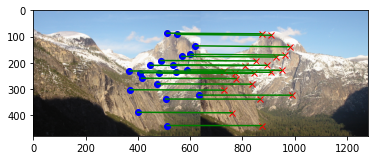

0
32


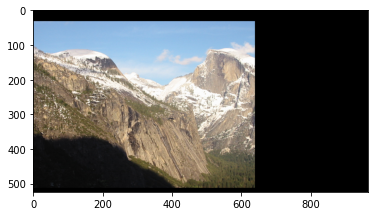

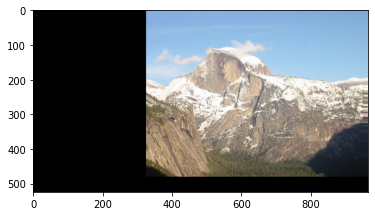

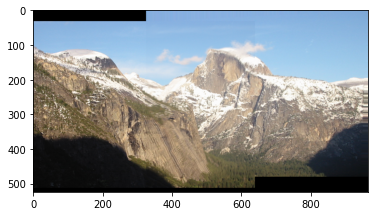

In [20]:
"""
Script (do not modify)
"""

# load images in OpenCV BGR format
I1 = cv2.imread('yosemite1.jpg')
I2 = cv2.imread('yosemite2.jpg')

# create grayscale images
I1_gray = cv2.cvtColor(I1, cv2.COLOR_BGR2GRAY)
I2_gray = cv2.cvtColor(I2, cv2.COLOR_BGR2GRAY)

# convert images to RGB format for display
I1 = cv2.cvtColor(I1, cv2.COLOR_BGR2RGB)
I2 = cv2.cvtColor(I2, cv2.COLOR_BGR2RGB)

# compute SIFT features
sift = cv2.xfeatures2d.SIFT_create()
kp1, des1 = sift.detectAndCompute(I1_gray, None)
kp2, des2 = sift.detectAndCompute(I2_gray, None)

# match features
match, match_fwd, match_bkwd = match_features(des1, des2)

# get corresponding points p1, p2 
p1 = np.array([kp.pt for kp in kp1])[match[:, 0]]
p2 = np.array([kp.pt for kp in kp2])[match[:, 1]]

# plot first 20 matching points 
plot_corr(I1, I2, p1[:20], p2[:20])

# estimate homography transform with RANSAC
H = ransac_homography(p1, p2)

# stitch two images together and show the results
I = stitch(I1,I2,H)

plt.figure()
plt.imshow(I)
plt.show()